# Multivariate Multistep TimeSeries 실습

- 가구의 Energy 사용량 예측

- Household Power Consumption Dataset 은 한 가구의 4 년간 전력소비를 나타내는 multivariate time series dataset 임

- data는  분 단위 관측값으로 구성

- variables :  

    - global active power: 가구에서 소비한 총 유효전력 (total active power, kilowatts).
    - global reactive power: 가구에서 소비한 총 무효전력 (total reactive power, kilowatts).
    - voltage: 평균 voltage (volts).
    - global intensity: 평균 전류 밀도 (amps).
    - sub metering 1: 주방에서 사용된 active energy (watt-hours of active energy).
    - sub metering 2: 세탁에 사용된 active energy (watt-hours of active energy).
    - sub metering 3: 공조기 제어 시스템에 사용된 active energy (watt-hours of active energy).

- 기타 다른 곳에서 시용된 active energy $\left(\frac{global\_act\_pwr  \times  1000}{60} \right) - \left(sub met 1 + sub met 2 + sub met 3\right) $ 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [2]:
url = "https://raw.githubusercontent.com/ironmanciti/Time_Series_Lecture/main/datasets/household_power_consumption_days.csv"
dataset = pd.read_csv(url, index_col=['datetime'], parse_dates=True)

print(dataset.shape)
print(dataset.info())
dataset.head()

(1442, 8)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1442 entries, 2006-12-16 to 2010-11-26
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    1442 non-null   float64
 1   Global_reactive_power  1442 non-null   float64
 2   Voltage                1442 non-null   float64
 3   Global_intensity       1442 non-null   float64
 4   Sub_metering_1         1442 non-null   float64
 5   Sub_metering_2         1442 non-null   float64
 6   Sub_metering_3         1442 non-null   float64
 7   Sub_metering_4         1442 non-null   float64
dtypes: float64(8)
memory usage: 101.4 KB
None


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
datetime,,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.933319
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0,36946.666732
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0,19028.433281
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0,13131.900043
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0,20384.800011


## Exploratory Data Analysis(탐색적 데이터 분석)

#### multivariate data 이므로 각각의 변수에 대해 line plot 을 그려 비교 (기간 : 2006 Dec 에서 2010 Nov 까지)

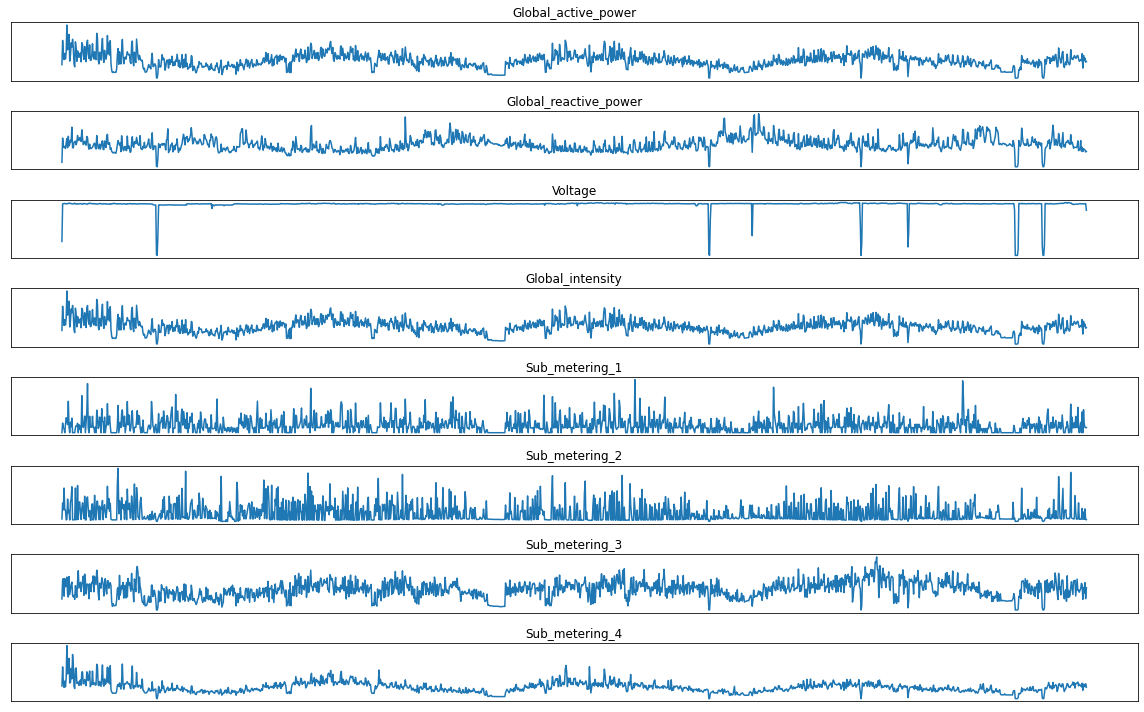

In [3]:
plt.figure(figsize=(16, 10))
for i in range(len(dataset.columns)):
    plt.subplot(len(dataset.columns), 1, i+1)
    name = dataset.columns[i]
    plt.plot(dataset[name])
    plt.title(name)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

## 개별 변수에 대하여 분석

#### Global_active_power (총 소비전력)를 연도별로 plot

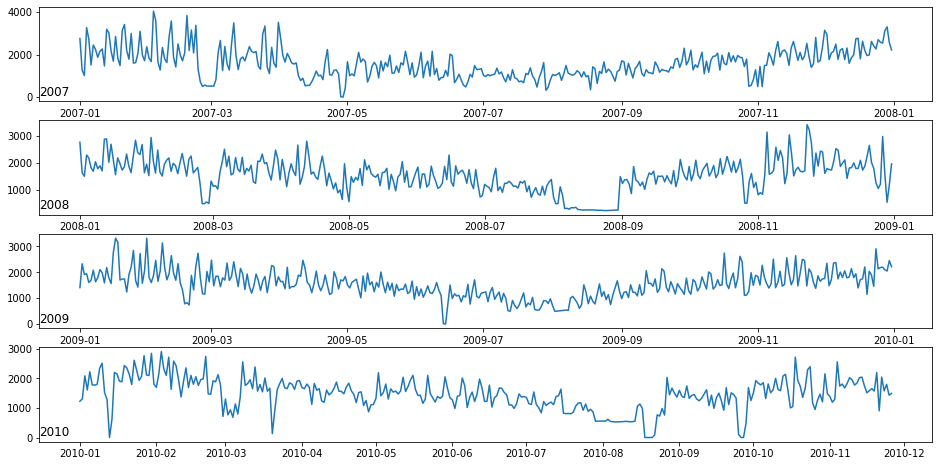

In [4]:
years = ['2007', '2008', '2009', '2010']

plt.figure(figsize=(16, 8))
for i in range(len(years)):
    ax = plt.subplot(len(years), 1, i+1)
    ax.plot(dataset.loc[years[i], 'Global_active_power'])
    ax.set_title(years[i], y=0, loc='left')

#### Global_active_power 를 특정연도(2007) 의 월별로 plot

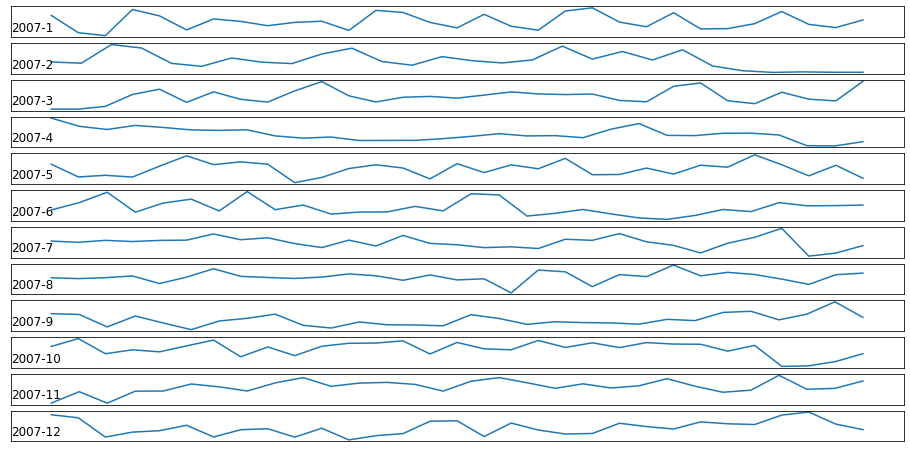

In [5]:
months = [i for i in range(1, 13)]
plt.figure(figsize=(16, 8))
for i in range(len(months)):
    ax = plt.subplot(len(months), 1, i+1)
    YYMM = '2007-' + str(months[i])
    result = dataset.loc[YYMM]
    ax.plot(result['Global_active_power'])
    ax.set_title(YYMM, y=0, loc='left')
    ax.set_xticks([])
    ax.set_yticks([])

#### Global_active_power 를 특정연도(2007) 의 특정월(January)의 일별로 plot

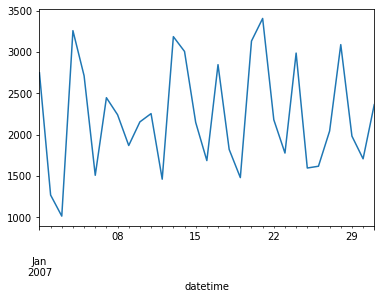

In [6]:
day1 = '2007-01-01'
day2 = '2007-01-31'
result = dataset.loc[day1:day2]
result['Global_active_power'].plot()

## 문제

- Multivariate multi-step forecasting (다변수 다단계 예측)

- next week 의 일별 전력 사용량(global active power) 예측  
    

- 이전 7일간의 전력 사용량으로 next week 사용량을 예측 하므로 window_size = 7 

In [7]:
dataset.shape

(1442, 8)

In [8]:
dataset.index.year.value_counts()

2008    366
2007    365
2009    365
2010    330
2006     16
Name: datetime, dtype: int64

## Train – Test Split

2010년 이 330 record 이므로 2010년을 Test set 으로 사용하고 이전 data를 Train set 으로 분할

In [9]:
split_time = dataset.shape[0] - 330

time_train = dataset.index[:split_time]
time_test = dataset.index[split_time:]

d_train = dataset.values[:split_time]
d_test  = dataset.values[split_time:]

time_train.shape, time_test.shape, d_train.shape, d_test.shape

((1112,), (330,), (1112, 8), (330, 8))

## Scaling the values 
- 다변수 문제 이므로 feature value 들을 normalize

In [10]:
sc = StandardScaler()
d_train_scaled = sc.fit_transform(d_train)
d_test_scaled = sc.transform(d_test)

In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda w: (w[:-1], w[1:]))    # label 은 Global_active_power
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [12]:
window_size = 7  # week size
n_features = 8   #  multivariate
shuffle_buffer = 100
batch_size = 64
train_ds = windowed_dataset(d_train_scaled, window_size, batch_size, shuffle_buffer)
test_ds = windowed_dataset(d_test_scaled, window_size, batch_size, shuffle_buffer)
print(train_ds)
print(test_ds)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 8), dtype=tf.float64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 8), dtype=tf.float64, name=None))>


In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(window_size, 8), return_sequences=True),
    tf.keras.layers.LSTM(64,  return_sequences=True),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(1),
])

model.compile(loss='mse', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 64)             18688     
                                                                 
 lstm_1 (LSTM)               (None, 7, 64)             33024     
                                                                 
 dense (Dense)               (None, 7, 120)            7800      
                                                                 
 dense_1 (Dense)             (None, 7, 1)              121       
                                                                 
Total params: 59,633
Trainable params: 59,633
Non-trainable params: 0
_________________________________________________________________


In [14]:
%%time
history = model.fit(train_ds, epochs=50, verbose=2)

Epoch 1/50
18/18 - 10s - loss: 0.9338 - 10s/epoch - 561ms/step
Epoch 2/50
18/18 - 0s - loss: 0.8923 - 400ms/epoch - 22ms/step
Epoch 3/50
18/18 - 0s - loss: 0.8769 - 315ms/epoch - 17ms/step
Epoch 4/50
18/18 - 0s - loss: 0.8648 - 321ms/epoch - 18ms/step
Epoch 5/50
18/18 - 0s - loss: 0.8517 - 267ms/epoch - 15ms/step
Epoch 6/50
18/18 - 0s - loss: 0.8417 - 254ms/epoch - 14ms/step
Epoch 7/50
18/18 - 0s - loss: 0.8316 - 313ms/epoch - 17ms/step
Epoch 8/50
18/18 - 0s - loss: 0.8275 - 261ms/epoch - 14ms/step
Epoch 9/50
18/18 - 0s - loss: 0.8247 - 296ms/epoch - 16ms/step
Epoch 10/50
18/18 - 0s - loss: 0.8237 - 343ms/epoch - 19ms/step
Epoch 11/50
18/18 - 0s - loss: 0.8201 - 345ms/epoch - 19ms/step
Epoch 12/50
18/18 - 0s - loss: 0.8183 - 297ms/epoch - 16ms/step
Epoch 13/50
18/18 - 0s - loss: 0.8138 - 408ms/epoch - 23ms/step
Epoch 14/50
18/18 - 0s - loss: 0.8105 - 270ms/epoch - 15ms/step
Epoch 15/50
18/18 - 0s - loss: 0.8087 - 176ms/epoch - 10ms/step
Epoch 16/50
18/18 - 0s - loss: 0.8038 - 184ms/epo

`d_test_scaled`의 첫번째 column (`Global_active_power`)을 y_test 로 저장

In [15]:
y_test = np.array([day[0] for day in d_test_scaled])
y_test.shape

(330,)

In [16]:
prediction = model.predict(test_ds)[:, -1, 0]
prediction.shape

(323,)

원래 크기로 denormalize

In [17]:
y_true = y_test * sc.scale_[0] + sc.mean_[0]
y_pred = prediction * sc.scale_[0] + sc.mean_[0]

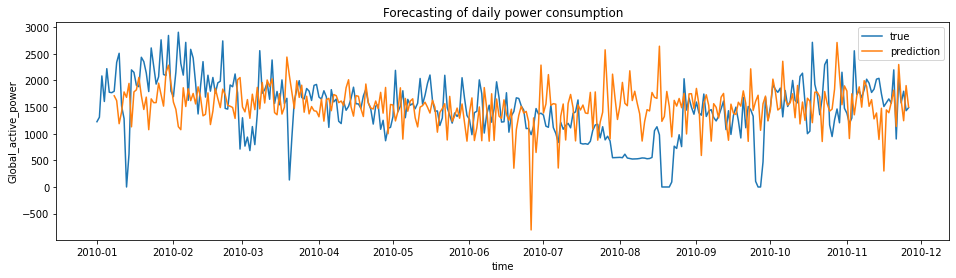

In [18]:
plt.figure(figsize=(16, 4))
plt.plot(time_test, y_true, label='true')
plt.plot(time_test[-len(y_pred):], y_pred, label='prediction')
plt.xlabel("time")
plt.ylabel("Global_active_power")
plt.title("Forecasting of daily power consumption")
plt.legend()